# 1. Introducción

Una red neuronal siamesa (o [Siamese neural network](https://en.wikipedia.org/wiki/Siamese_neural_network)), a veces llamada red neuronal gemela, es una red neuronal artificial que utiliza los mismos pesos mientras trabaja en conjunto con dos vectores de entrada diferentes para calcular vectores de salida comparables. A menudo, uno de los vectores de salida se precomputa, formando así una referencia contra la cual se compara el otro vector de salida. Esto es similar a comparar huellas dactilares, pero puede describirse más técnicamente como una función de distancia para hashing sensible a la localidad.

Vamos a crear una red siamesa para aprender una métrica que permita calcular similitudes y diferencias entre diferentes tipos de imágenes.

<img src="https://i.ibb.co/FV4pj65/siamese.png" alt="Alex-Net-architecture" border="0" />

In [1]:
!pip install tensorflow-datasets


  Using cached tensorflow_datasets-4.9.7-py3-none-any.whl.metadata (9.6 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached immutabledict-4.2.1-py3-none-any.whl.metadata (3.5 kB)
  Using cached promise-2.3.tar.gz (19 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached simple_parsing-0.1.6-py3-none-any.whl.metadata (7.3 kB)
  Using cached tensorflow_metadata-1.16.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached etils-1.10.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached importlib_resources-6.4.5-py3-none-any.whl.metadata (4.0 kB)
  Using cached docstring_parser-0.16-py3-none-any.whl.metadata (3.0 kB)
  Using cached googleapis_common_protos-1.66.0-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached tensorflow_datasets-4.9.7-py3-none-any.whl (5.3 MB)
Using cached etils-1.10.0-py3-none-any.whl (164 kB)
Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
   ----------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.30.0 requires protobuf<5,>=3.20, but you have protobuf 5.28.3 which is incompatible.


In [3]:
!pip install tensorflow


  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
     ---------------------------------------- 0.0/48.7 kB ? eta -:--:--
     ---------------------------------------- 48.7/48.7 kB ? eta 0:00:00
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/390.2 MB ? eta -:--:--
   ---------------------------------------- 1.4/390.2 MB 29.6 MB/s eta 0:00:14
   ---------------------------------------- 3.2/390.2 MB 33.4 MB/s eta 0:00:12
    --------------------------------------- 5.2/390.2 MB 36.8 MB/s eta 0:00:11
    --------------------------------------- 7

In [4]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import time

# 2. Ejemplo con Fashion MNIST

El conjunto de datos Fashion MNIST contiene 70,000 imágenes en escala de grises divididas en 10 categorías. Las imágenes muestran artículos individuales de ropa a baja resolución (28 por 28 píxeles).

## 2.1. Cargar dataset

In [5]:
# Cargar el dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Conjuntos de entrenamiento y prueba
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Normalizar valores

train_images = train_images / 255.0
test_images = test_images / 255.0

# Nombre de las clases
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt',
    'Sneaker', 'Bag', 'Ankle boot'
]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Se crean tripletas donde el ancla y el positivo tienen la misma clase.
# El negativo tiene diferente clase
def crear_tripletas(images, labels, n_triplets_per_class=10000):
    triplets = []
    n_labels = len(np.unique(labels))

    for class_ind in range(n_labels):
        pos_class_inds = np.where(labels == class_ind)[0]
        neg_class_inds = np.where(labels != class_ind)[0]

        for _ in range(n_triplets_per_class):
            anchor = images[np.random.choice(pos_class_inds)]
            positive = images[np.random.choice(pos_class_inds)]
            negative = images[np.random.choice(neg_class_inds)]
            triplets.append((anchor, positive, negative))

    return np.array(triplets)




In [8]:
tripletas_train = crear_tripletas(train_images, train_labels, 10000)

In [9]:
tripletas_train.shape

(100000, 3, 28, 28)

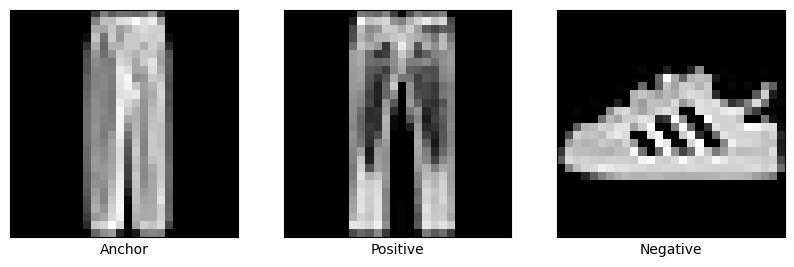

In [10]:
plt.figure(figsize=(10,10))
ind = np.random.randint(len(tripletas_train))
labels = ['Anchor', 'Positive', 'Negative']
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(tripletas_train[ind,i,:,:], cmap='gray')
    plt.xlabel(labels[i])
plt.show()


# 3. Triplet Loss

- **A** es el "Anchor" (ancla).
- **P** es el "Positive" (positivo).
- **N** es el "Negative" (negativo).

Una tripleta de entrenamiento $(A^{(i)}, P^{(i)}, N^{(i)})$ representa la $i$-ésima tripleta en el conjunto de entrenamiento.

El objetivo es garantizar que una imagen $A^{(i)}$ (ancla) esté **más cerca** de la imagen positiva $P^{(i)}$ que de la imagen negativa $N^{(i)}$ por al menos un margen $\alpha$. Este objetivo se puede expresar matemáticamente como:

$$
\|\mathrm{vec}(A^{(i)}) - \mathrm{vec}(P^{(i)})\|_2^2 + \alpha < \|\mathrm{vec}(A^{(i)}) - \mathrm{vec}(N^{(i)})\|_2^2
$$

Aquí:
- $\|\mathrm{vec}(A^{(i)}) - \mathrm{vec}(P^{(i)})\|_2^2$: Distancia euclidiana al cuadrado entre la ancla y el positivo.
- $\|\mathrm{vec}(A^{(i)}) - \mathrm{vec}(N^{(i)})\|_2^2$: Distancia euclidiana al cuadrado entre la ancla y el negativo.
- $\alpha$: El margen, que es un valor positivo que define la diferencia mínima deseada entre estas distancias.

#### **Función de costo de la tripleta**

El objetivo es minimizar la siguiente función de costo:

$$
\mathcal{J}(A, P, N) = \sum_{i=1}^{m} \max \left( \underbrace{\|\mathrm{vec}(A^{(i)}) - \mathrm{vec}(P^{(i)})\|_2^2}_\text{(1)} - \underbrace{\|\mathrm{vec}(A^{(i)}) - \mathrm{vec}(N^{(i)})\|_2^2}_\text{(2)} + \alpha, 0 \right)
$$

**Desglose de la ecuación:**
1. El término (1) es la distancia cuadrada entre el ancla y el positivo. **Queremos que este valor sea lo más pequeño posible**, indicando que las imágenes similares están cercanas.
    ```python
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    ```
2. El término (2) es la distancia cuadrada entre el ancla y el negativo. **Queremos que este valor sea relativamente grande**, indicando que las imágenes disímiles están separadas. El signo negativo delante de este término indica que estamos minimizando el costo total.
    ```python
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    ```
3. $\alpha$ es el margen. Este término asegura que la diferencia entre las distancias (positiva y negativa) sea lo suficientemente significativa para separar las clases.

#### **Resumen del objetivo**
La función de pérdida de tripletas **penaliza** los casos en los que:
- El ancla está demasiado cerca de la imagen negativa.
- El ancla no está lo suficientemente cerca de la imagen positiva.

Esto garantiza que las representaciones generadas por la red sean útiles para tareas de clasificación o búsqueda basadas en similitudes.

#### Código simplificado:
```python
# Distancia positiva: entre ancla y positivo
pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)

# Distancia negativa: entre ancla y negativo
neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)

# Cálculo de la pérdida de tripletas
loss = tf.maximum(pos_dist - neg_dist + alpha, 0)
```

In [11]:
def triplet_loss(y_true, y_pred, margin = 0.2):
  anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
  pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
  neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
  loss = tf.maximum(pos_dist - neg_dist + margin, 0.0)
  return tf.reduce_mean(loss)


def distancia_euclidiana(vec1, vec2):
  return tf.reduce_sum(tf.square(vec1 - vec2))

# 4. Crear Modelo
Primero, creamos el base_model compartido.

In [12]:
vec_dim = 64

inputs = tf.keras.Input(shape=(28,28,))
x = layers.Flatten(name="flatten_input")(inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.25, name="second_dropout")(x)

x = layers.Dense(vec_dim, activation='linear')(x)
# L2 normalize
x = layers.Lambda(lambda z: tf.math.l2_normalize(z,axis=1))(x)

base_model = tf.keras.Model(inputs=inputs, outputs=x, name='base_model')

base_model.summary()

Model: "base_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_input (Flatten)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_dropout (Dropout)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 64)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,248 (489.25 KB)

 Trainable params: 125,248 (489.25 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Input tripletas (anchor, positive, negative)
inputs = tf.keras.Input(shape=(3, 28, 28), name='inputs')

## Anchor vector
anchor_input = inputs[:, 0, :, :]
anchor_vec = base_model(anchor_input)

## Positive vector
positive_input = inputs[:, 1, :, :]
positive_vec = base_model(positive_input)

## Negative vector
negative_input = inputs[:, 2, :, :]
negative_vec = base_model(negative_input)

## apilar dimensiones: (3, none, vec_dim)
outputs = tf.keras.layers.Lambda(lambda x: tf.stack(x, axis=0))([anchor_vec, positive_vec, negative_vec])
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [15]:
y = np.zeros(len(tripletas_train))

In [16]:
model.compile(loss=triplet_loss,optimizer='adam')
history = model.fit(tripletas_train, y, epochs=3, validation_split=0.15, batch_size=128, shuffle=True)

Epoch 1/3
665/665 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0617 - val_loss: 0.0321
Epoch 2/3
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0330 - val_loss: 0.0231
Epoch 3/3
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0279 - val_loss: 0.0338


In [17]:
image = test_images[5]
image_vec = base_model(np.expand_dims(image, 0))
image.shape, image_vec.shape, image_vec

((28, 28),
 TensorShape([1, 64]),
 <tf.Tensor: shape=(1, 64), dtype=float32, numpy=
 array([[ 0.19429035,  0.06842804,  0.25819883,  0.00102345, -0.00448802,
         -0.13985108, -0.16138797, -0.24639343, -0.12603761,  0.08485635,
          0.06030009,  0.10430185, -0.05806793,  0.15143451,  0.05017306,
         -0.07900449,  0.05552892, -0.04419175, -0.00238232, -0.01277786,
          0.10832828,  0.07721876,  0.07145028,  0.07756045,  0.06612789,
          0.19749808, -0.06932823,  0.10462575,  0.02228405,  0.14007802,
         -0.11570787,  0.07783131, -0.01010155,  0.25625563, -0.093216  ,
          0.03486327,  0.05467396, -0.09995836,  0.3257436 ,  0.14532903,
         -0.28848988,  0.00215154,  0.01820179,  0.20535186, -0.22054033,
         -0.00291929, -0.06407235,  0.12302069, -0.11547743, -0.07937928,
          0.09473807,  0.02855309,  0.04115181,  0.1174975 , -0.2667008 ,
         -0.13262759,  0.05421913,  0.04580107, -0.11893809, -0.04354142,
         -0.08296485, -0.025

--------------------------------------------------------------------------------
T-shirt/top 0


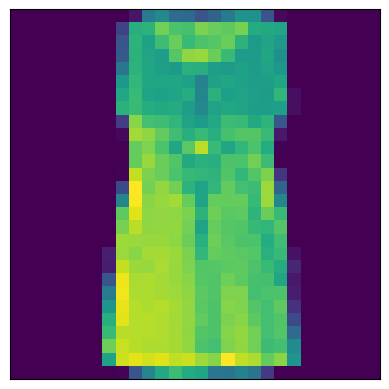

distances:
--------------------------------------------------------------------------------
Trouser 1


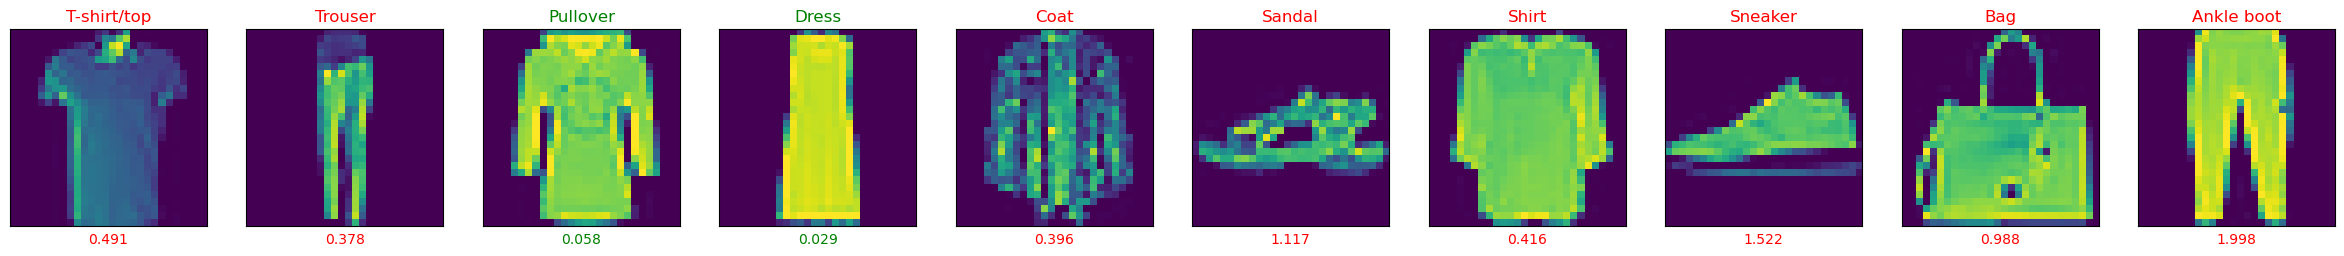

distances:
--------------------------------------------------------------------------------
Pullover 2


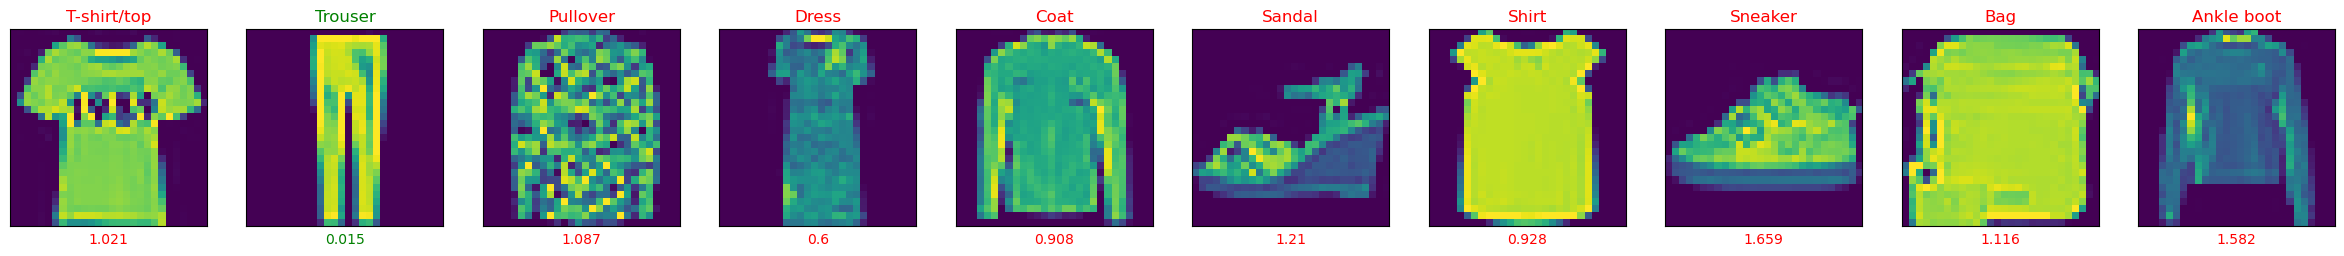

distances:
--------------------------------------------------------------------------------
Dress 3


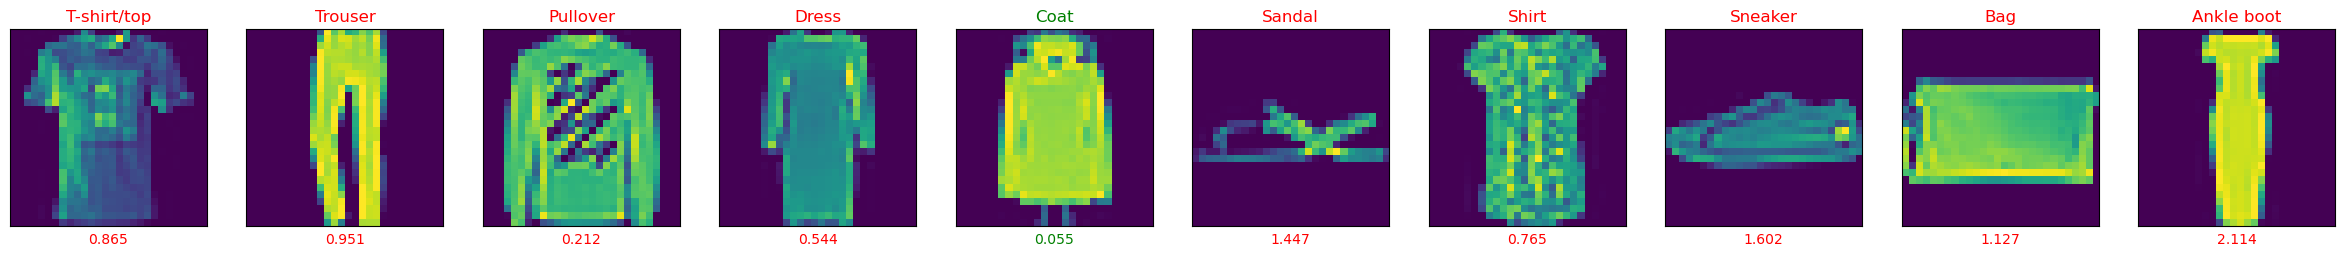

distances:
--------------------------------------------------------------------------------
Coat 4


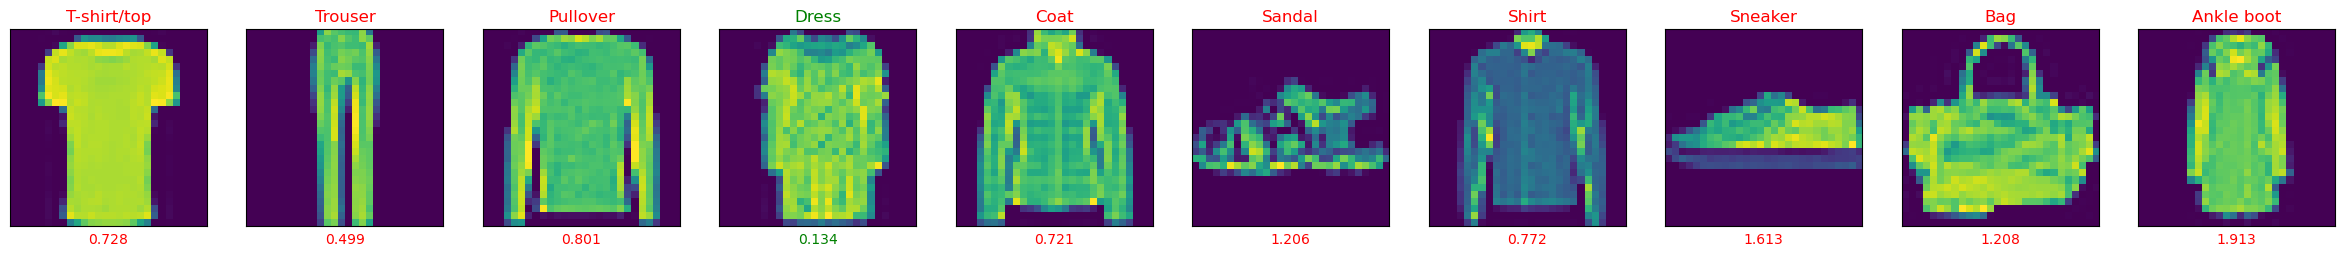

distances:
--------------------------------------------------------------------------------
Sandal 5


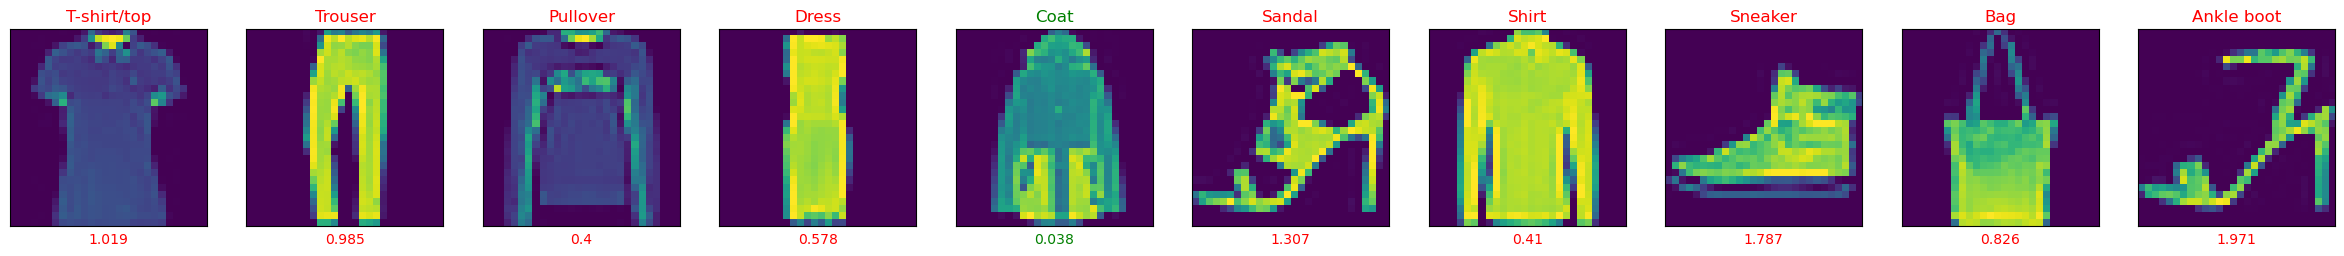

distances:
--------------------------------------------------------------------------------
Shirt 6


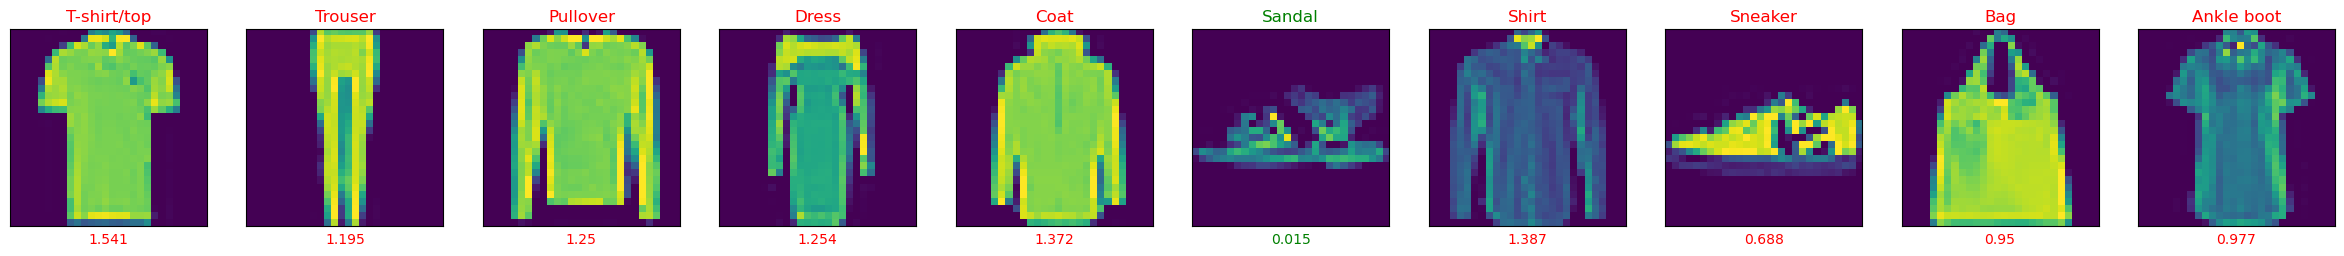

distances:
--------------------------------------------------------------------------------
Sneaker 7


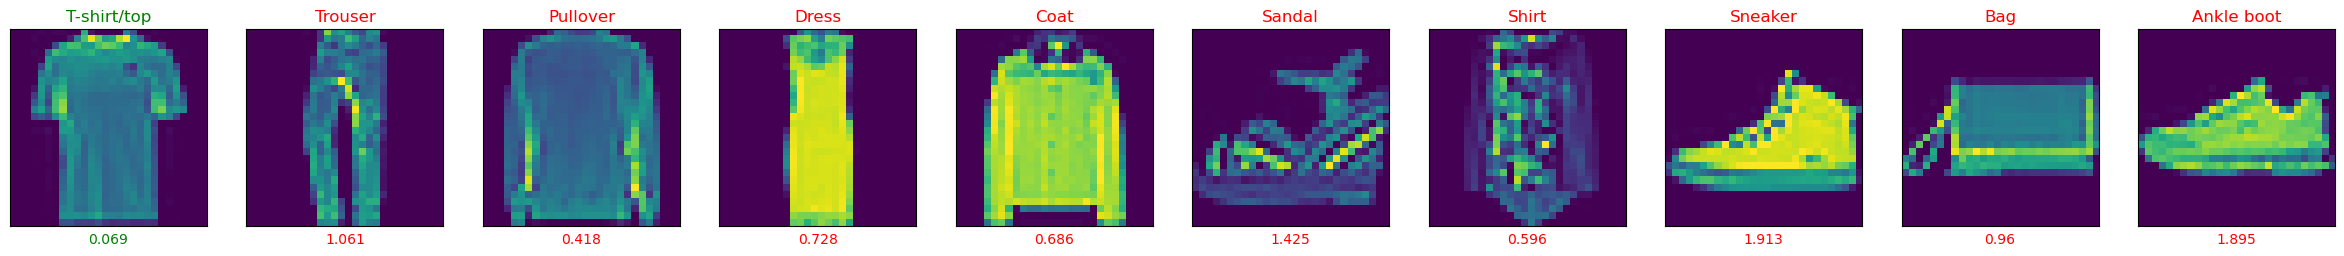

distances:
--------------------------------------------------------------------------------
Bag 8


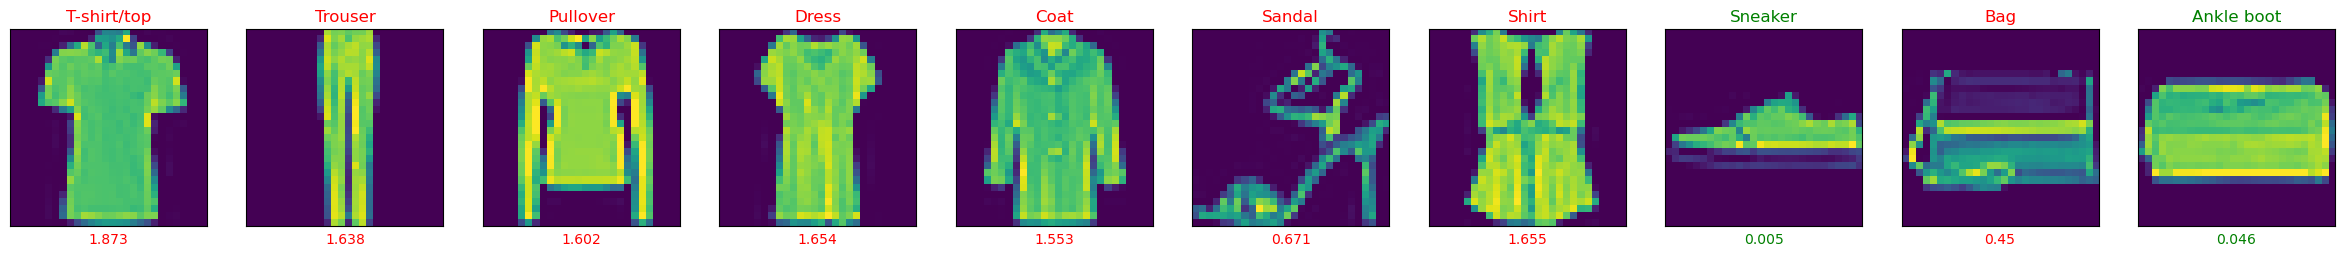

distances:
--------------------------------------------------------------------------------
Ankle boot 9


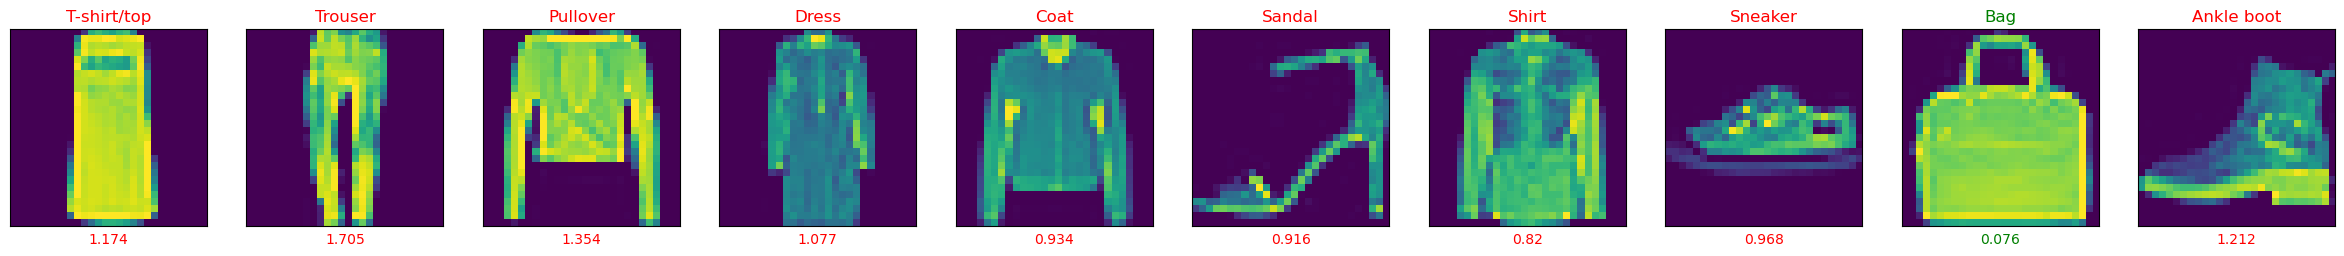

distances:


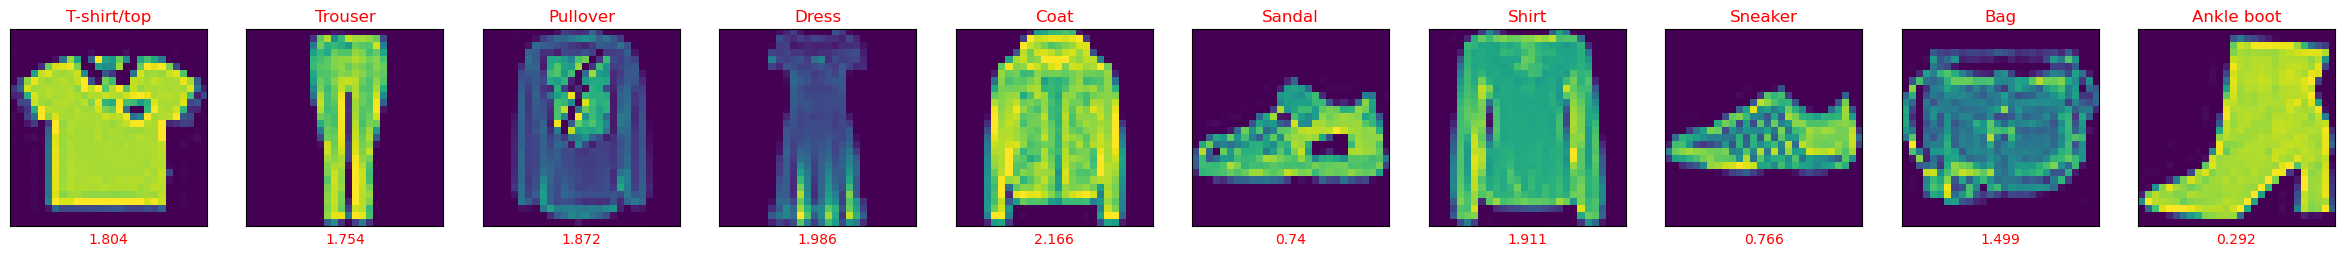

In [18]:
def grafica_dis_imagenes(base_model, image_vec, images, labels, class_names, margin=0.2):
  plt.figure(figsize=(30, 30))
  for class_ind in range(len(class_names)):
    class_name = class_names[class_ind]
    class_inds = np.argwhere(labels == class_ind).flatten()
    image_class = np.squeeze(images[np.random.choice(class_inds)])
    image_class_vec = base_model(np.expand_dims(image_class, 0))
    dis = np.round(distancia_euclidiana(image_vec, image_class_vec), 3)
    dis_str = str(dis)
    if dis < margin:
      color = 'green'
    else:
      color = 'red'
    plt.subplot(1, len(class_names), class_ind + 1)
    plt.title(class_name, color=color)
    plt.xlabel(dis_str, color=color)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_class)
plt.show()

for class_ind in range(10):
  print('-'*80)
  class_name = class_names[class_ind]
  print(class_name, class_ind)
  class_inds = np.argwhere(test_labels == class_ind).flatten()
  image = np.squeeze(test_images[np.random.choice(class_inds)])
  image_vec = base_model(np.expand_dims(image, 0))

  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.show()
  print('distances:')
  grafica_dis_imagenes(base_model, image_vec, test_images, test_labels, class_names)

# 5. Similutud y matriz de confusión

In [19]:
def calcular_clase_mas_cercana(image_vec, image_class, vecs, labels):
    # Los vectores están normalizados: argmin_i |v -v_i| = argmax_i v_i.dot(v)
    mas_similar = np.argsort(-vecs.dot(image_vec))[1]

    # El índice 0 es para el mismo vector
    clase_mas_cercana = labels[mas_similar]

    return clase_mas_cercana


def calcular_matriz_confusion(vecs, labels, class_names, samples=20):
  num_classes = len(class_names)
  matriz_confusion = np.zeros((num_classes, num_classes))
  for class_ind in range(num_classes):
    pos_class_inds = np.argwhere(labels == class_ind).flatten()
    class_samples = np.random.choice(pos_class_inds, samples)
    for sample_ind in class_samples:
      image_vec = vecs[sample_ind, :]
      nn_class = calcular_clase_mas_cercana(image_vec, class_ind, vecs,
                                               labels)
      matriz_confusion[class_ind, nn_class] += 1
  return matriz_confusion

In [20]:
test_vecs = base_model(test_images).numpy()
matriz_confusion = calcular_matriz_confusion(test_vecs,
                                              test_labels,
                                              class_names,
                                              samples=99)

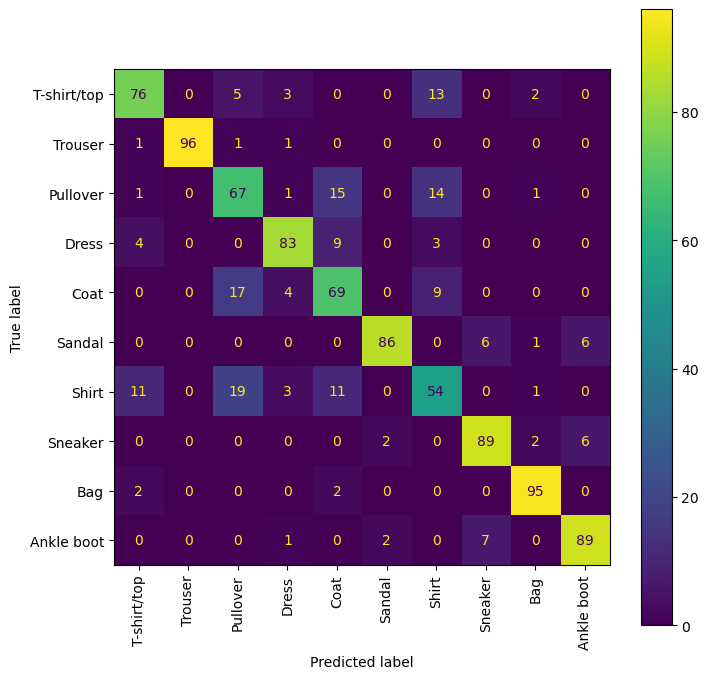

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
cmp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion,
                             display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 8));
cmp.plot(ax=ax, xticks_rotation="vertical", include_values=True)

In [22]:
def calcular_clase_diferente_mas_cercana(image_vec, image_class, vecs, labels):
  neg_class_inds = np.argwhere(labels != image_class).flatten()
  neg_vecs = vecs[neg_class_inds, :]
  most_similar_ind = np.argmax(neg_vecs.dot(image_vec))
  nearest_class = labels[neg_class_inds[most_similar_ind]]
  return nearest_class

def calcular_clases_cercanas(vecs, labels, class_names, samples=20):
  num_classes = len(class_names)
  nearest_classes = np.zeros((num_classes, num_classes))
  for class_ind in range(num_classes):
    pos_class_inds = np.argwhere(labels == class_ind).flatten()
    class_samples = np.random.choice(pos_class_inds, samples)
    for sample_ind in class_samples:
      image_vec = vecs[sample_ind, :]
      nn_class = calcular_clase_diferente_mas_cercana(image_vec, class_ind, vecs,
                                                    labels)
      nearest_classes[class_ind, nn_class] += 1
  return nearest_classes




In [23]:
test_vecs = base_model(test_images).numpy()
matriz_confusion = calcular_clases_cercanas(test_vecs,
                                              test_labels,
                                              class_names,
                                              samples=50)

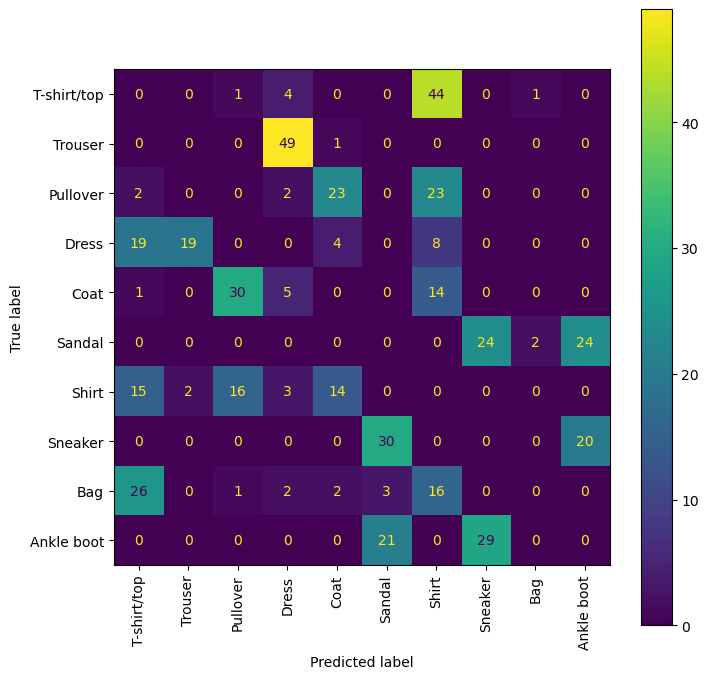

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
cmp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation="vertical", include_values=True);

# 6. Ejercicios

## Ejercicio 1:

Crear un modelo base convolucional

In [25]:
(train_images,
 train_labels), (test_images,
                 test_labels) = tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images / 255.0
test_images = test_images / 255.0

train_images = np.expand_dims(train_images, -1)
test_images = np.expand_dims(test_images, -1)

class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt',
    'Sneaker', 'Bag', 'Ankle boot'
]

In [26]:
tripletas_train = crear_tripletas(train_images, train_labels, 10000)
tripletas_train.shape

(100000, 3, 28, 28, 1)

In [27]:
vec_dim = 64

inputs = tf.keras.Input(shape=(28, 28, 1))

## convolutional layers
# Conv Layer 1
x = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs) # Added filters, kernel_size, and activation
x = layers.MaxPooling2D(pool_size=(2, 2))(x) # Added pool_size


## Flatten layer
flat = layers.Flatten()(x) # Added Flatten layer call


## Output vector
x = layers.Dense(vec_dim)(flat)  # Assuming you want a dense layer with vec_dim neurons, connected to the flattened output
# L2 normalize
outputs = layers.Lambda(lambda z: tf.math.l2_normalize(z,axis=1))(x)


base_model = tf.keras.Model(inputs=inputs, outputs=outputs, name='base_model')

base_model.summary()

Model: "base_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │       346,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 64)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,496 (1.32 MB)

 Trainable params: 346,496 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Input triplets (anchor, positive, negative)
inputs = tf.keras.Input(shape=(3, 28, 28, 1), name='inputs')

## Anchor vector
anchor_input = inputs[:, 0, :, :, :]
anchor_vec = base_model(anchor_input)

## Positive vector
positive_input = inputs[:, 1, :, :, :]
positive_vec = base_model(positive_input)

## Negative vector
negative_input = inputs[:, 2, :, :, :]
negative_vec = base_model(negative_input)

## stack all the vectors dim: (3, none, vec_dim)
# Wrap tf.stack in a Lambda layer
outputs = layers.Lambda(lambda x: tf.stack(x, axis=1))([anchor_vec, positive_vec, negative_vec])
# Note: axis=1 to stack along the correct dimension

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [30]:
# In [22]
train_triplets = crear_tripletas(train_images, train_labels, 10000)
train_triplets.shape

# In [29]
y = np.zeros(len(train_triplets)) # train_triplets is now defined

In [31]:
model.compile(loss=triplet_loss,optimizer='adam')
history = model.fit(train_triplets, y, epochs=8, validation_split=0.15, batch_size=128, shuffle=True)

Epoch 1/8
665/665 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - loss: 0.2012 - val_loss: 0.2003
Epoch 2/8
665/665 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 0.2006 - val_loss: 0.1992
Epoch 3/8
665/665 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.1988 - val_loss: 0.1983
Epoch 4/8
665/665 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.1999 - val_loss: 0.1990
Epoch 5/8
665/665 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.1997 - val_loss: 0.1995
Epoch 6/8
665/665 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.2003 - val_loss: 0.1997
Epoch 7/8
665/665 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.2000 - val_loss: 0.2000
Epoch 8/8
665/665 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - loss: 0.2000 - val_loss: 0.2001


### Resultados

--------------------------------------------------------------------------------
T-shirt/top 0


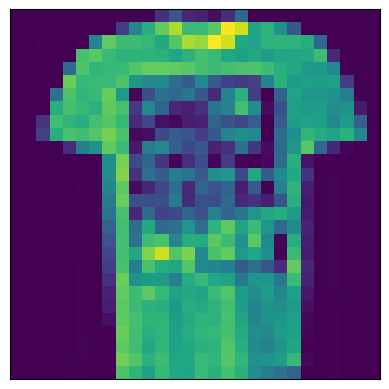

distances:


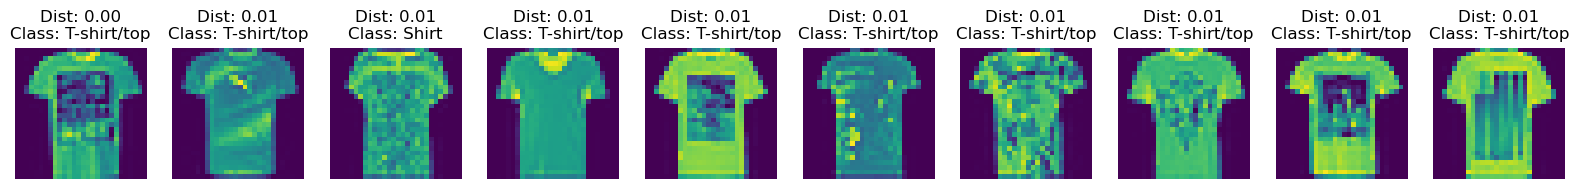

--------------------------------------------------------------------------------
Trouser 1


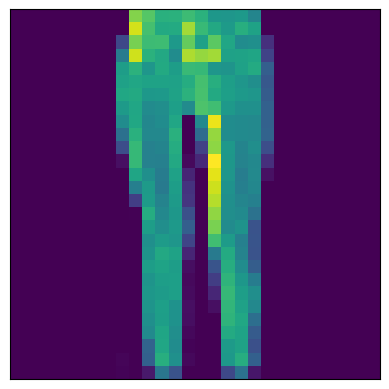

distances:


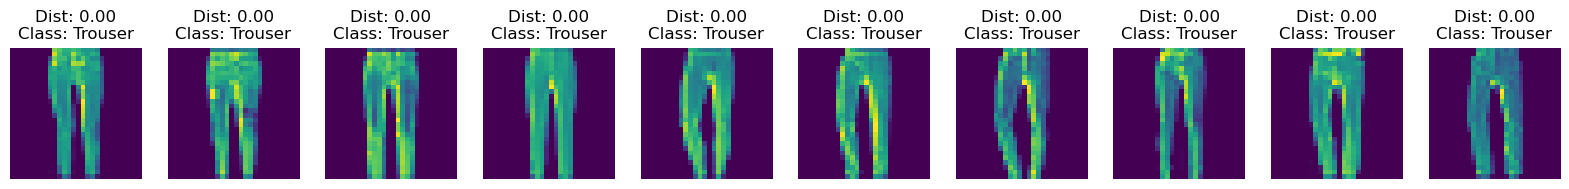

--------------------------------------------------------------------------------
Pullover 2


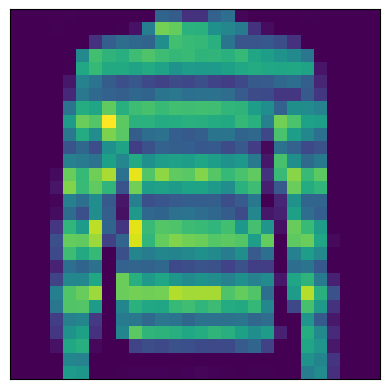

distances:


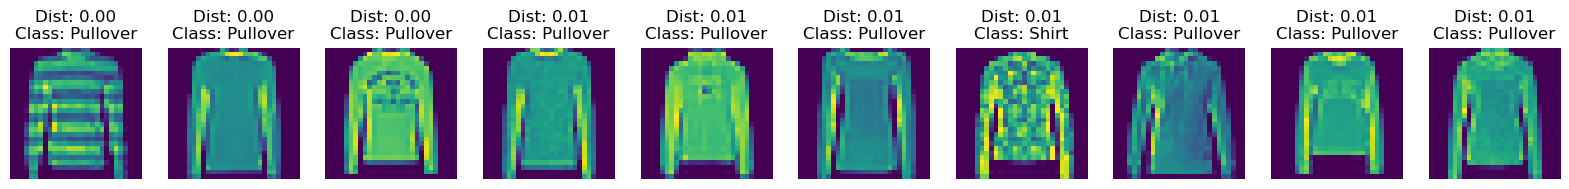

--------------------------------------------------------------------------------
Dress 3


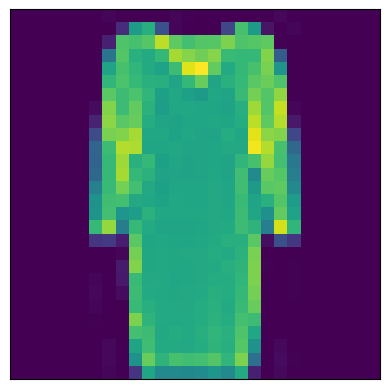

distances:


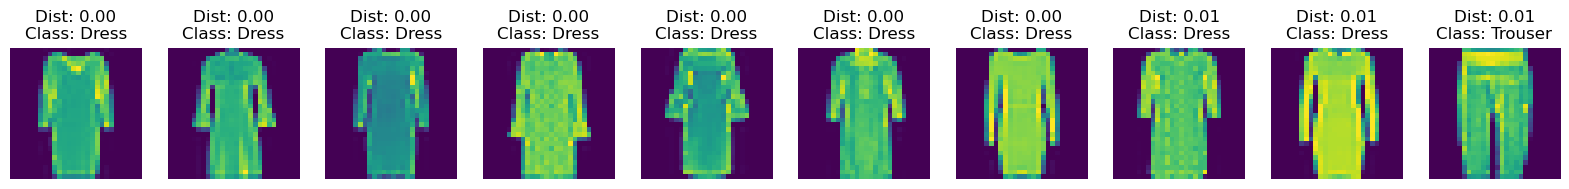

--------------------------------------------------------------------------------
Coat 4


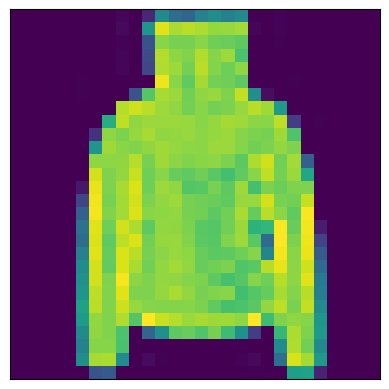

distances:


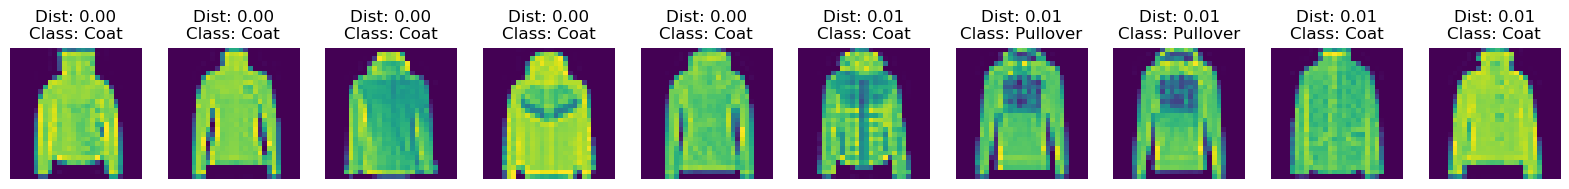

--------------------------------------------------------------------------------
Sandal 5


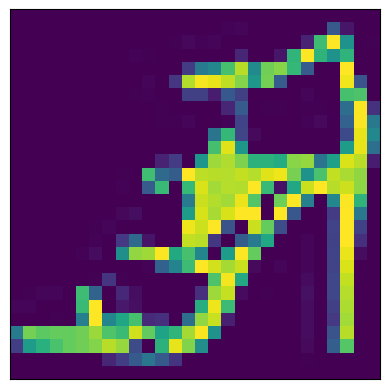

distances:


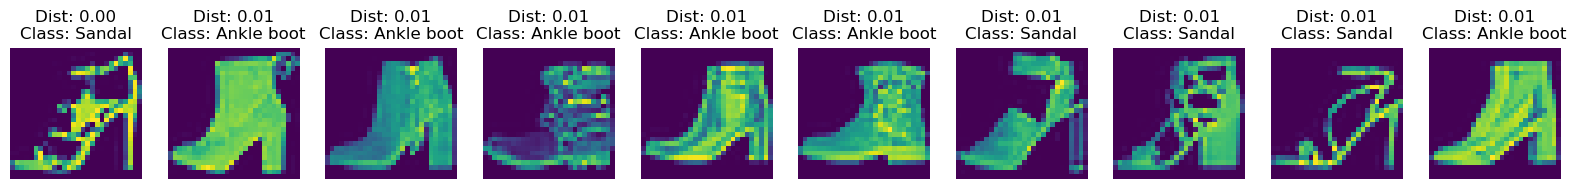

--------------------------------------------------------------------------------
Shirt 6


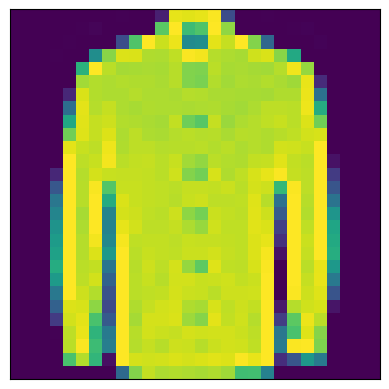

distances:


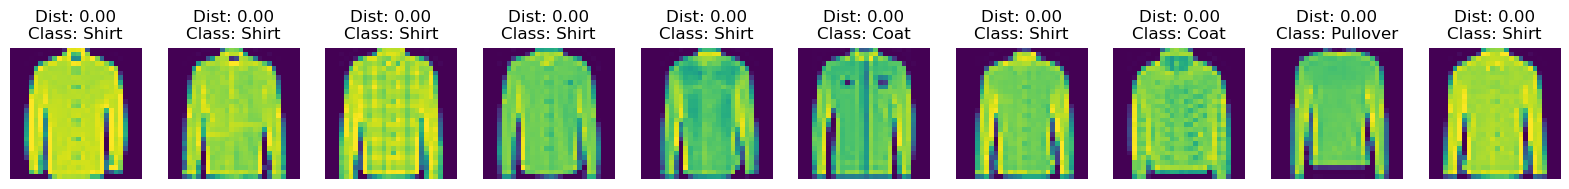

--------------------------------------------------------------------------------
Sneaker 7


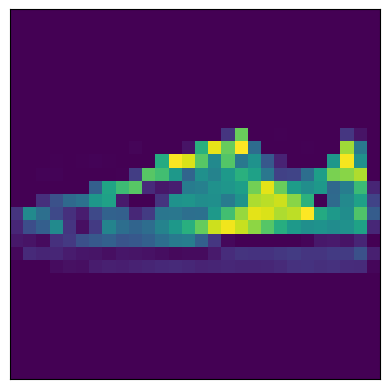

distances:


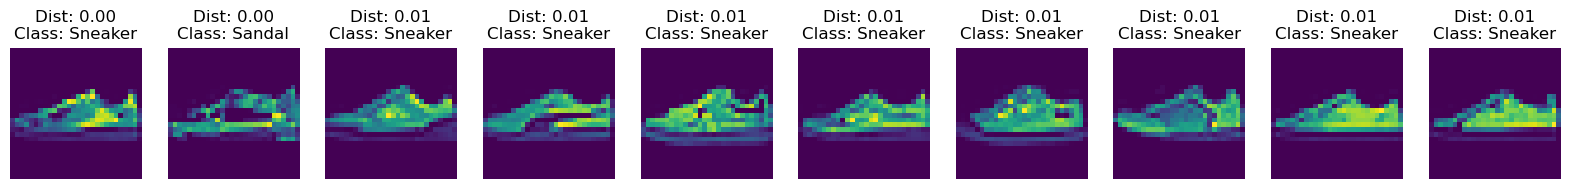

--------------------------------------------------------------------------------
Bag 8


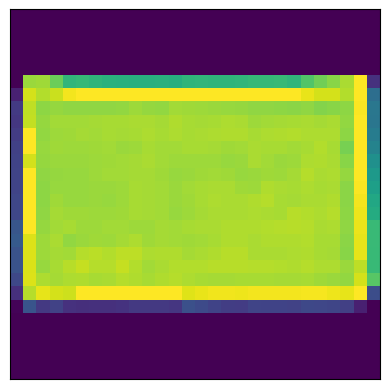

distances:


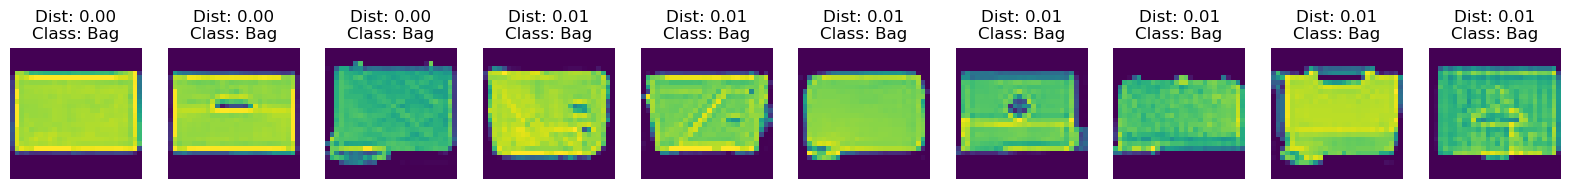

--------------------------------------------------------------------------------
Ankle boot 9


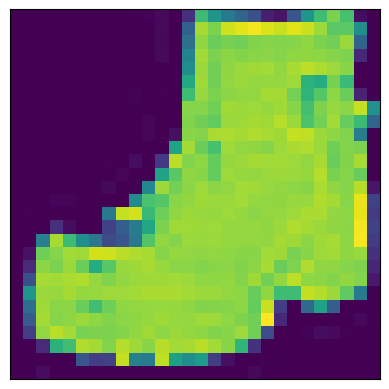

distances:


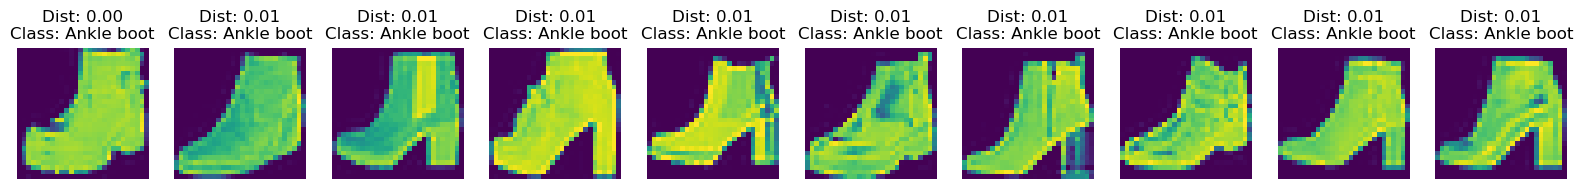

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_dis(base_model, image_vec, images, labels, class_names, num_images=10):
    distances = []
    for img in images:
        img_vec = base_model(np.expand_dims(img, 0))
        distance = np.linalg.norm(image_vec - img_vec)
        distances.append(distance)

    # Sort images by distance
    sorted_inds = np.argsort(distances)

    # Plot images
    fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
    for i in range(num_images):
        ax = axes[i]
        img_ind = sorted_inds[i]
        ax.imshow(np.squeeze(images[img_ind]))
        ax.set_title(f"Dist: {distances[img_ind]:.2f}\nClass: {class_names[labels[img_ind]]}")
        ax.axis('off')

    plt.show()


# --- Your existing code ---

for class_ind in range(10):
    print('-'*80)
    class_name = class_names[class_ind]
    print(class_name, class_ind)
    class_inds = np.argwhere(test_labels == class_ind).flatten()
    image = np.squeeze(test_images[np.random.choice(class_inds)])
    image_vec = base_model(np.expand_dims(image, 0))

    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.show()
    print('distances:')
    plot_images_dis(base_model, image_vec, test_images, test_labels, class_names)

### Confusion matrix

In [33]:
test_vecs = base_model(test_images).numpy()
matriz_confusion = calcular_matriz_confusion(test_vecs,
                                              test_labels,
                                              class_names,
                                              samples=99)

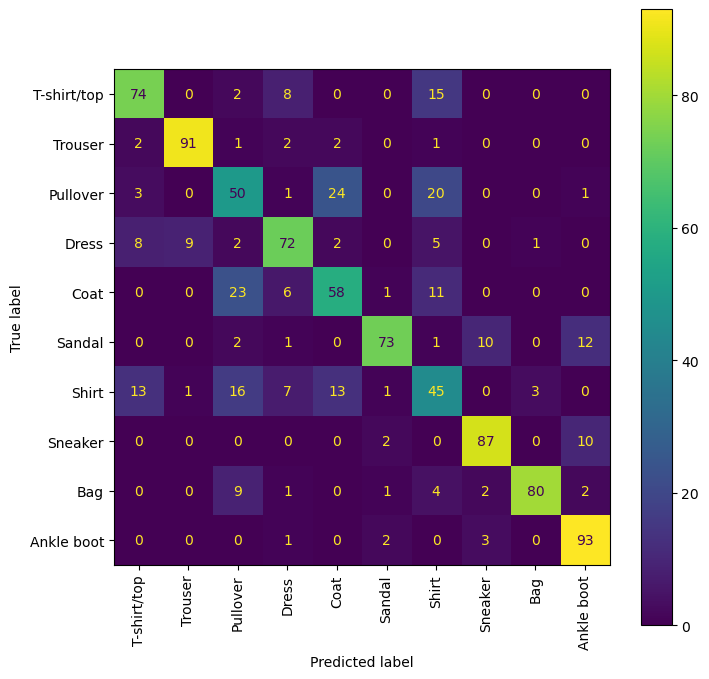

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay
cmp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion,
                             display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 8));
cmp.plot(ax=ax, xticks_rotation="vertical", include_values=True)

In [35]:
import gc
del train_triplets, train_images, test_images
gc.collect()

30250

## Ejercicio 2

Repite el proceso con el conjunto de datos de flores, que contiene aproximadamente 3700 fotografías de flores de 5 clases diferentes. Utilice un modelo previamente entrenado para el modelo base.

In [36]:
import pathlib
import tensorflow as tf
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [37]:
image_size = (80, 80)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset=
    'training',
    seed=1,
    image_size=image_size,
    batch_size=1
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=1,
    image_size=image_size,
    batch_size=1
)

Found 3670 files belonging to 1 classes.
Using 2936 files for training.
Found 3670 files belonging to 1 classes.
Using 734 files for validation.


In [38]:
class_names = train_ds.class_names
class_names

['flower_photos']

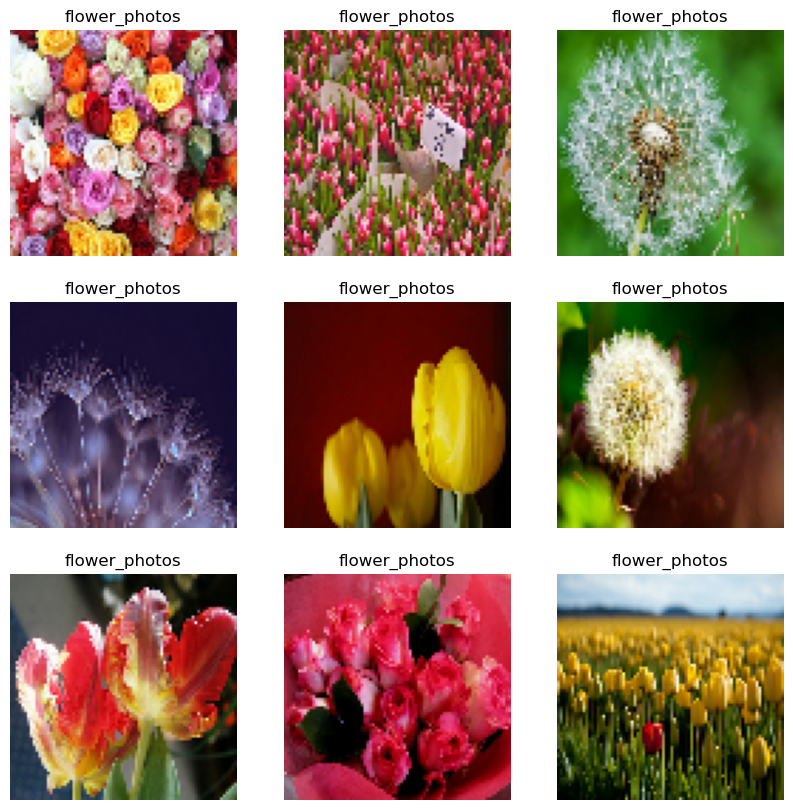

In [39]:
plt.figure(figsize=(10, 10))
for i, (images, labels) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(class_names[labels[0]])
    plt.axis("off")

In [40]:
train_images, train_labels = zip(*[
    (items[0][0], items[1][0]) for items in train_ds.as_numpy_iterator()
])
train_images = np.array(train_images)
train_images = train_images / 255.0
train_labels = np.array(train_labels)
train_images.shape, train_labels.shape

((2936, 80, 80, 3), (2936,))

In [41]:
test_images, test_labels = zip(*[
    (items[0][0], items[1][0]) for items in val_ds.as_numpy_iterator()
])
test_images = np.array(test_images)
test_images = test_images / 255.0
test_labels = np.array(test_labels)
test_images.shape, test_labels.shape

((734, 80, 80, 3), (734,))

In [42]:
import numpy as np

def create_triplets(images, labels, num_triplets):

    triplets = []
    num_classes = len(np.unique(labels))

    for _ in range(num_triplets):
        # Randomly select an anchor image
        anchor_index = np.random.randint(0, len(images))
        anchor_label = labels[anchor_index]

        # Find a positive image with the same label as the anchor
        positive_index = anchor_index
        while positive_index == anchor_index or labels[positive_index] != anchor_label:
            positive_index = np.random.randint(0, len(images))

        # Find a negative image with a different label from the anchor
        negative_index = anchor_index
        while negative_index == anchor_index or labels[negative_index] == anchor_label:
            negative_index = np.random.randint(0, len(images))

        triplets.append([anchor_index, positive_index, negative_index])

    return np.array(triplets)

### Create the base model
Use a pre-trained model like `MobileNetV2`: [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications)

In [43]:
import tensorflow as tf
from tensorflow.keras import layers

vec_dim = 128

inputs = tf.keras.Input(shape=image_size + (3,))

# Load a pre-trained model (e.g., MobileNetV2)
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=image_size + (3,), include_top=False, weights='imagenet'
)

# Freeze the pre-trained layers
pretrained_model.trainable = False

# Preprocess inputs if needed
# ...

# Flatten layer
flat = layers.Flatten()(pretrained_model.output)

# Output vector
outputs = layers.Dense(vec_dim)(flat)

# L2 normalize
outputs = layers.Lambda(lambda z: tf.math.l2_normalize(z, axis=1))(outputs)

base_model = tf.keras.Model(inputs=inputs, outputs=outputs, name='base_model')

base_model.summary()

C:\Users\manza\AppData\Local\Temp\ipykernel_4700\3096527357.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "base_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 80, 80, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 40, 40,    │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 40, 40,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 40, 40,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 40, 40,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 40, 40,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 40, 40,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 40, 40,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 40, 40,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 40, 40,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 40, 40,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 40, 40,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 41, 41,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 20, 20,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 20, 20,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 20, 20,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 20, 20,    │      2,304 │ block_1_depthwis

 Total params: 3,732,672 (14.24 MB)

 Trainable params: 1,474,688 (5.63 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [44]:
import tensorflow as tf
from tensorflow.keras import layers

# Input triplets (anchor, positive, negative)
inputs = tf.keras.Input(shape=(3, 80, 80, 3), name='inputs')

## Anchor vector
anchor_input = inputs[:, 0, :, :, : ]
anchor_vec = base_model(anchor_input)

## Positive vector
positive_input = inputs[:, 1, :, :,:]
positive_vec = base_model(positive_input)

## Negative vector
negative_input = inputs[:, 2, :, :,:]
negative_vec = base_model(negative_input)

## stack all the vectors dim: (3, none, vec_dim)
# Wrap tf.stack within a Lambda layer
outputs = layers.Lambda(lambda x: tf.stack(x, axis=1))([anchor_vec, positive_vec, negative_vec])

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [45]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [46]:
import tensorflow as tf
from tensorflow.keras import layers

# Input triplets (anchor, positive, negative)
inputs = tf.keras.Input(shape=(3, 80, 80, 3), name='inputs')

# Reshape input to (None, 3, 80, 80, 3)
reshape_layer = layers.Reshape((3, 80, 80, 3))(inputs)

def process_image(image):
    # image is already in the correct shape (80, 80, 3)
    return base_model(image)

outputs = layers.Lambda(lambda x: tf.map_fn(process_image, x), output_shape=(3, vec_dim))(reshape_layer)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
train_triplets = create_triplets(train_images, train_labels, 5)
train_triplets.shape

# In [29]
y = np.zeros(len(train_triplets)) # train_triplets is now defined
model.compile(loss=triplet_loss,optimizer='adam')
history = model.fit(train_triplets, y, epochs=8, validation_split=0.15, batch_size=128, shuffle=True)